In [2]:
# Import all needed packages in this box.
import pandas as pd
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read in the .csv file.
# Path should be relative to the directory where 'jupyter notebook' is run.
path_to_csv_file = "./data/example_data.csv"
df = pd.read_csv(path_to_csv_file, header=0)
print(df)

     age  population_size      deaths
0      0       4224138.50    0.160000
1      1       4291025.96    0.160000
2      2       4367810.86    0.160000
3      3       4413079.21    0.160000
4      4       4414124.72    0.160000
..   ...              ...         ...
96    96        158443.80  359.733333
97    97        113346.44  359.733333
98    98         74993.86  359.733333
99    99         49773.22  359.733333
100  100         33101.57  359.733333

[101 rows x 3 columns]


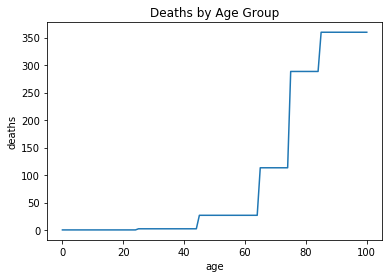

In [4]:
# NOTE: df["age"] returns a pd.Series, which we turn into a np.array with '.values'.
ages = df["age"].values
deaths = df["deaths"].values
plt.plot(ages, deaths)
plt.title("Deaths by Age Group")
plt.xlabel('age')
plt.ylabel('deaths')
plt.show()

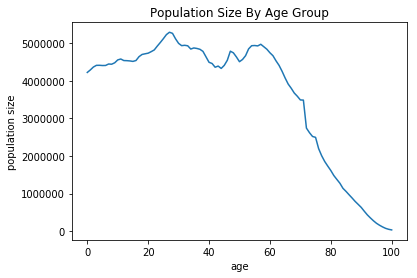

In [5]:
ages = df["age"].values
deaths = df["population_size"].values
plt.plot(ages, deaths)
plt.title("Population Size By Age Group")
plt.xlabel('age')
plt.ylabel('population size')
plt.show()

In [6]:
def death_rate_model(age, alpha, tau):
    """
    The functional form of the death rate model.
    
    age (np.array) : A 1D numpy array of ages
    alpha (float) : alpha model parameter
    tau (float) : tau model parameter
    """
    return alpha * 2**(age / tau)

In [9]:
def plot_model(df, alpha, tau):
    """
    Convenience function for plotting the simulated deaths under given alpha and tau values. 
    """
    # Extract columns from the dataframe.
    ages = df["age"].values
    population_size = df["population_size"].values
    actual_deaths = df["deaths"].values
    assert(len(ages) == len(population_size))

    # Calculate simulated deaths based on alpha and tau guess.
    simulated_rates = death_rate_model(ages, alpha, tau)
    simulated_deaths = simulated_rates * population_size 

    # Plot the result against the actual deaths.
    plt.plot(ages, actual_deaths, color="red", label="Actual Deaths")
    plt.plot(ages, simulated_deaths, color="blue", label="Simulated Deaths")
    plt.title("Simulated vs. Actual Deaths")
    plt.xlabel('age')
    plt.ylabel('deaths')
    plt.legend()
    plt.show()

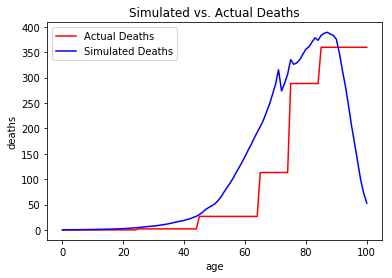

In [10]:
# Guess a value for alpha and tau.
alpha = 8e-8
tau = 7
plot_model(df, alpha, tau)

** PROBLEM SETUP **
INITIAL GUESS:
   [8.e-08 7.e+00]
POPULATION SIZES:
  OVERALL=363064516.5700001 UNDER70=323739098.53
AGE RANGE:
  min=0 max=100
ACTUAL DEATH RATES:
  OVERALL=0.00003 UNDER70=0.0000035
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 133
         Function evaluations: 247
** OPTIMIZATION RESULT **
* alpha=1.7930307073116382e-09 
* tau=4.818513962546017
* Ran 133 iterations of downhill simplex algorithm


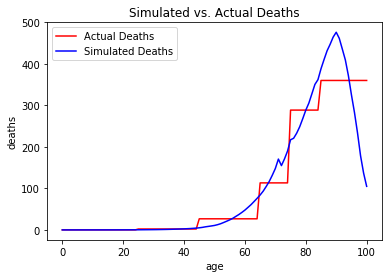

In [18]:
def error_function(model_parameters,
                   ages,
                   pop_sizes,
                   N_overall,
                   N_under70,
                   actual_rate_overall,
                   actual_rate_under70):
    """
    Computes the error of our model using the current guess for alpha and tau in model_parameters.
    This error function is what we try to *minimize* during the optimization.
    
    NOTE(milo): Instead of computing the error between simulated death rates and true death rates, I'm
    computing the error between simulated *deaths* and true *deaths*. Errors in terms of rate will be
    really tiny, because the death rates are so small (e.g 0.0044), and might make the optimization
    "think" it's found a good solution when it hasn't.
    
    Args:
        model_parameters (np.array) : An array with (2) elements [alpha, tau]
        ages (np.array) : An array (probably length 101) with ages
        pop_sizes (np.array) : An array (probably length 101) with the population size for each age
        N_overall (float) : Total population
        N_under70 (float) : Total population under 70
        actual_rate_overall (float) : Observed overall death rate
        actual_rate_under70 (float) : Observed under-70 death rate
    """
    assert(len(ages) == len(pop_sizes)) # Should have a 1:1 correspondence.
    
    alpha = model_parameters[0]
    tau = model_parameters[1]
    
    sim_rates = death_rate_model(ages, alpha, tau)
    sim_deaths = pop_sizes * sim_rates
    
    overall_deaths = np.sum(sim_deaths)
    under70_deaths = np.sum(sim_deaths[ages < 70])
    
    # Use a squared error (always nonnegative).
    sq_err_overall = (overall_deaths - actual_rate_overall*N_overall)**2
    sq_err_under70 = (under70_deaths - actual_rate_under70*N_under70)**2
    
    total_error = sq_err_overall + sq_err_under70

    return total_error

#====================================================================
# We want to optimize alpha and tau so that simulated overall death rate
# and under-70 death rate match the observed values.
# NOTE: I'm not sure what the best way to get these values into the .csv
# file is, since they're just a single number and not a column. For now
# I'm just hardcarding them here.
# ACTUAL_DEATH_RATE_OVERALL = 0.0044
# ACTUAL_DEATH_RATE_UNDER70 = 0.05

# Extract columns from the dataframe.
ages = df["age"].values
pop_sizes = df["population_size"].values
actual_deaths = df["deaths"].values

# Make sure all data columns are the same length.
assert(len(ages) == len(pop_sizes) and len(ages) == len(actual_deaths))

# Start off with an initial guess for alpha/tau.
# I got this one by playing around with the previous plot until it looked ok.
ALPHA_GUESS = 8e-8
TAU_GUESS = 7
guess = np.array([ALPHA_GUESS, TAU_GUESS])

# Pre-compute N_overall and N_under70 once.
N_overall = np.sum(pop_sizes)
N_under70 = np.sum(pop_sizes[ages < 70])

ACTUAL_DEATH_RATE_OVERALL = np.sum(actual_deaths) / N_overall
ACTUAL_DEATH_RATE_UNDER70 = np.sum(actual_deaths[ages < 70]) / N_under70

print("** PROBLEM SETUP **")
print("INITIAL GUESS:\n  ", guess)
print("POPULATION SIZES:\n  OVERALL={} UNDER70={}".format(N_overall, N_under70))
print("AGE RANGE:\n  min={} max={}".format(ages[0], ages[-1]))
print("ACTUAL DEATH RATES:\n  OVERALL={:.5f} UNDER70={:.7f}".format(
        ACTUAL_DEATH_RATE_OVERALL, ACTUAL_DEATH_RATE_UNDER70))
print("========================================================================")

# Use scipy to find the minimum of the error function.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html
args_tuple = (ages,
              pop_sizes,
              N_overall,
              N_under70,
              ACTUAL_DEATH_RATE_OVERALL,
              ACTUAL_DEATH_RATE_UNDER70)

xopt, fopt, iter, funcalls, warnflag = optimize.fmin(error_function, guess, args=args_tuple, full_output=1)

# Parse the results from the optimization.
alpha_opt = xopt[0]
tau_opt = xopt[1]

print("** OPTIMIZATION RESULT **")
print("* alpha={} \n* tau={}".format(alpha_opt, tau_opt))
print("* Ran {} iterations of downhill simplex algorithm".format(iter))

# Plot the results!
plot_model(df, alpha_opt, tau_opt)